# Cat Classifier
Train a convolutional neural network to classify images of cats from dogs use tensorflow.

Images can be downloaded from: https://www.kaggle.com/c/dogs-vs-cats/data

In [1]:
import skimage
import numpy as np
from skimage import io
from catdog import data_io, models
from catdog.visualize import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

%matplotlib inline

/Users/matt/.virtualenvs/datasci/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# Make your plots pretty 
sns.set_context('poster')
sns.set_style('dark')
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['lines.markeredgewidth'] = 2
warnings.filterwarnings('ignore')

## Load training images
Load training images and labels into memory. Images are converted to grayscale and resized to 50x50. Labels are one-hot encoded:
    
    [1,0] = cat
    [0,1] = dog

Make sure to set data_io.TRAIN_DIR to the appropriate path, i.e., wherever you downloaded the training images.

In [3]:
data_io.TRAIN_DIR = './train/'
data, labels = data_io.load_training_images(n_images=2000, size=50)
class_names = ['cat', 'dog']

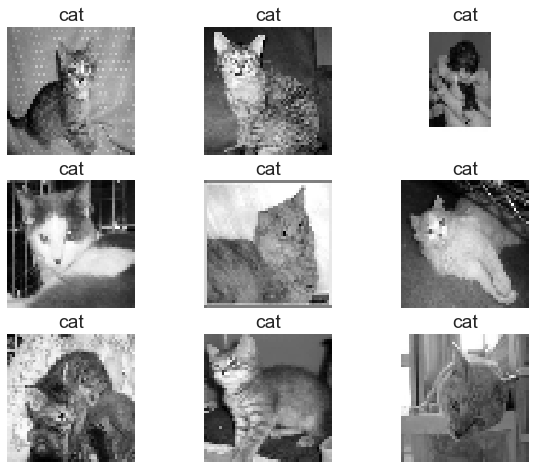

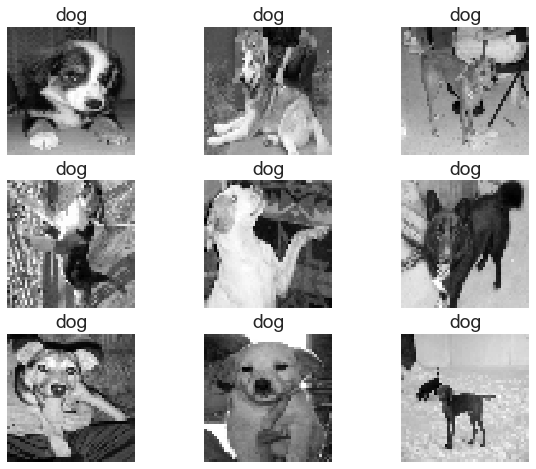

In [4]:
# Plot training images of each type
# Note that all cat images come before dog images

# Cat images
fig, axes = plt.subplots(nrows=3, ncols=3)
for ax, img, label in zip(axes.flatten(), data[:9], labels[:9]):
    ax.imshow(img, cmap='gray')
    ax.set_title(class_names[np.argmax(label)])
    # remove tick labels for clarity
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.yaxis.set_major_formatter(plt.NullFormatter())

# Dog images
fig, axes = plt.subplots(nrows=3, ncols=3)
for ax, img, label in zip(axes.flatten(), data[-10:-1], labels[-10:-1]):
    ax.imshow(img, cmap='gray')
    ax.set_title(class_names[np.argmax(label)])
    # remove tick labels for clarity
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.yaxis.set_major_formatter(plt.NullFormatter())

## Train a convolutional neural network (CNN)
First, split the data into training and testing sets. By default 75% of the data will be used for training and 25% for testing. Also, data will automatically be shuffled and partitioned into sets with an equal number of cat and dog images.

    x == data
    y == labels

Make sure to set the random_state in order to be able to reproduce the results!

In [5]:
# Training/testing split
x_train, x_test, y_train, y_test = train_test_split(data, labels, random_state=42)

In [6]:
# Build CNN model
# Note that the model depends on the size of the input images

size = data.shape[1]
model = models.build_cnn(size)

In [7]:
# CNN expects images of shape (nx_pixels, ny_pixels, n_channels)
# Also expects data of shape (n_images, nx_pixels, ny_pixels, n_channels)
# Since we converted to grayscale and don't have the last axis, we can expand the dimensions and add an extra axis

if len(x_train.shape) == 3:
    x_train = np.expand_dims(x_train, axis=3)

In [8]:
# Fit the model!
model.fit(x_train, y_train, epochs=100, batch_size=128)

Epoch 1/100
3000/3000 [==============================] - 30s 10ms/step - loss: 0.6940 - acc: 0.4783
Epoch 2/100
3000/3000 [==============================] - 30s 10ms/step - loss: 0.6936 - acc: 0.4990
Epoch 3/100
3000/3000 [==============================] - 30s 10ms/step - loss: 0.6944 - acc: 0.4987
Epoch 4/100
3000/3000 [==============================] - 30s 10ms/step - loss: 0.6934 - acc: 0.4947
Epoch 5/100
3000/3000 [==============================] - 29s 10ms/step - loss: 0.6931 - acc: 0.5083
Epoch 6/100
3000/3000 [==============================] - 29s 10ms/step - loss: 0.6944 - acc: 0.4890
Epoch 7/100
3000/3000 [==============================] - 28s 9ms/step - loss: 0.6915 - acc: 0.5207
Epoch 8/100
3000/3000 [==============================] - 29s 10ms/step - loss: 0.6922 - acc: 0.5283
Epoch 9/100
3000/3000 [==============================] - 29s 10ms/step - loss: 0.6925 - acc: 0.5340
Epoch 10/100
3000/3000 [==============================] - 30s 10ms/step - loss: 0.6863 - acc: 0.5440


## Model persistence
Save the model weights in order to use them later for predictions or to continue training.

```python
    model.save('trained_weights.h5')
```

You can easily load saved weights. First, compile the model and then load the weights:

```python
    model = models.build_cnn(size)
    model.load_weights('trained_weights.h5')
```

In [9]:
# weights_file = 'trained_weights.h5'
# model.save(weights_file)

In [8]:
weights_file = 'trained_weights.h5'
model.load_weights(weights_file)

## Evaluate model performance
Now that we have a trained model, we can use it make predictions on the testing set.

We'll plot a confusion matrix to see how well we're doing with each class and also plot the predicted probability distribution for the training and testing sets.

In [9]:
# Make sure test data has dimensions (n_images, nx_pixels, ny_pixels, n_channels)
if len(x_test.shape) == 3:
    x_test = np.expand_dims(x_test, axis=3)

In [10]:
# Get the predicted probabilities and classes for the testing set
y_probs_test = model.predict(x_test)
y_pred_test = model.predict_classes(x_test)

In [11]:
# Convert one-hot encoded y labels to binary 1/0
y_test_binary = np.argmax(y_test, axis=1)

# Get the confusion matrix and plot it
cm = confusion_matrix(y_test_binary, y_pred_test)

### Confusion matrix
The confusion matrix is a useful way to visualize the performance of a classifier. We can easily see how it performs with each class and where it's making the most mistakes. If we normalize the rows, then we can read off the relative probability of the classifier predicting each class, given a particular true label, i.e., 
    
    P(predict_cat | true_cat)
    
We're not doing *so* hot to start out, but we've only trained on 3000 images for 100 epochs. If we increased both of those numbers, we'd expect better performance! Of course we need to be careful about overfitting, but we'll save that for a different notebook. Also, none of the model parameters have been optimized at all. Not bad for the first try!

Text(0.5, 1.0, 'Row-normalized confusion matrix')

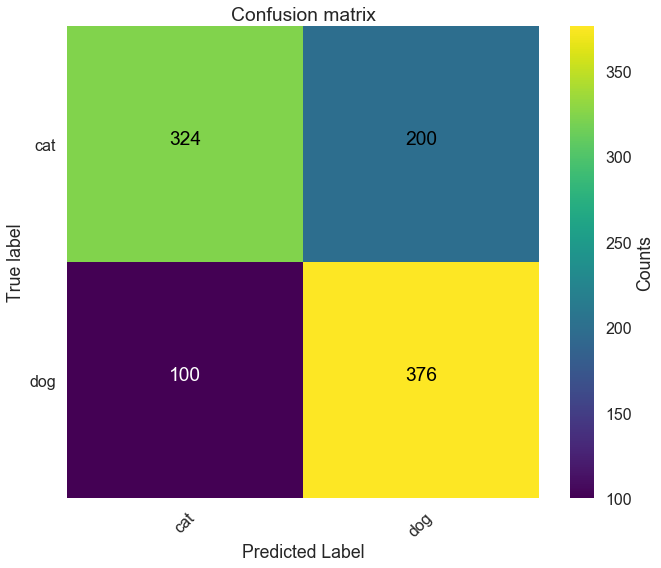

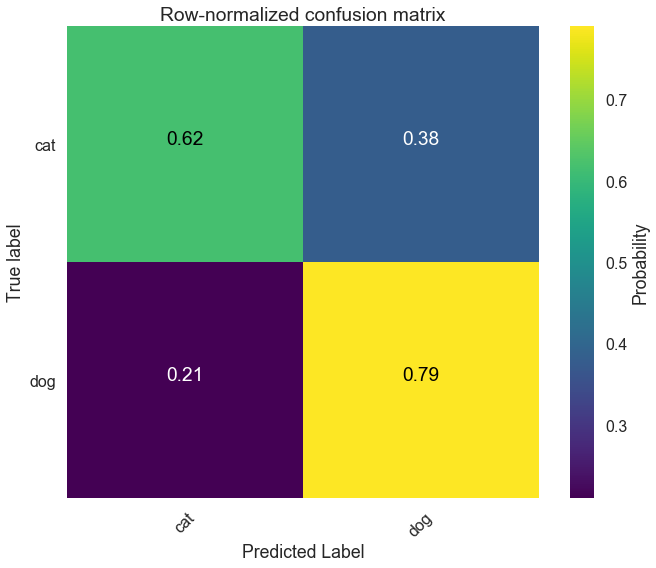

In [12]:
# Convert one-hot encoded y labels to binary 1/0
y_test_binary = np.argmax(y_test, axis=1)

# Get the confusion matrix and plot it
cm = confusion_matrix(y_test_binary, y_pred_test)

# Counts confusion matrix
fig, ax = plt.subplots()
ax = plot_confusion_matrix(cm, class_names, normalize=False, ax=ax)
ax.set_title('Confusion matrix')

# Normalized confusion matrix
fig, ax = plt.subplots()
ax = plot_confusion_matrix(cm, class_names, normalize=True, ax=ax)
ax.set_title('Row-normalized confusion matrix')

### Probability distributions
We plot the predicted probability distributions for the training and testing sets to see how they compare. 

In [13]:
# Get cat probabilities for training set to compare with testing set
y_probs_train = model.predict(x_train)

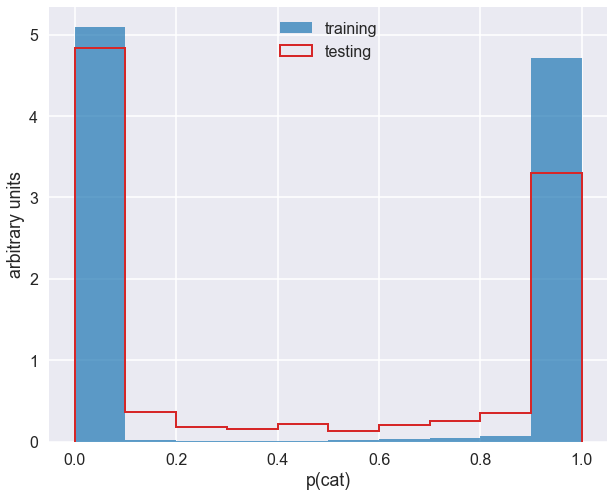

In [14]:
# Plot normalized historgams of cat probabilities for each set
fig, ax = plt.subplots()
ax.hist(y_probs_train[:,0], density=True, alpha=.7, label='training')
ax.hist(y_probs_test[:,0], density=True, histtype='step', lw=2, color='C3', label='testing')

ax.set_xlabel('p(cat)')
ax.set_ylabel('arbitrary units')
ax.legend(loc='upper center')
ax.grid()